In [370]:
include("TDCM_full_transition.jl")
include("data_generation.jl")
using Distributions

In [371]:
N, J, K, O, L, S = 5000, 24, 3, 3, 8, 50
num_features_gamma = 3
Q = [0 0 0; 0 0 1; 0 1 0; 1 0 0; 0 1 1; 1 0 1; 1 1 0; 1 1 1;
     0 0 0; 0 0 1; 0 1 0; 1 0 0; 0 1 1; 1 0 1; 1 1 0; 1 1 1;
     0 0 0; 0 0 1; 0 1 0; 1 0 0; 0 1 1; 1 0 1; 1 1 0; 1 1 1]

X = Vector{Vector{Matrix{Float64}}}(undef, K)
for k in 1:K
     X[k] = Vector{Matrix{Float64}}(undef, O)
     X[k][1] = ones(N, 1)
     for t in 2:O
          X[k][t] = Matrix{Float64}(undef, N, 3)
          X[k][t][:,1] = ones(N)
          X[k][t][:,2] = rand(Normal(0, 1), N)
          X[k][t][:,3] = rand(Bernoulli(0.5), N)
     end
end
U = Vector{Vector{Matrix{Float64}}}(undef, K)
for k in 1:K
     U[k] = Vector{Matrix{Float64}}(undef, O)
     for t in 1:O
          U[k][t] = Matrix{Float64}(undef, S, 3)
          U[k][t][:,1] = ones(S)
          U[k][t][:,2] = rand(Bernoulli(0.5), S)
          U[k][t][:,3] = rand(Bernoulli(0.5), S)
     end
end

In [372]:
data = data_generation(Q, X, U, Int(O), Int(K), Int(S), Int(N/S), beta_interact=true);

In [373]:
obs = TDCMObs(data.Y, data.Q, data.U, data.X, data.group);

In [374]:
rand_skills = Array{Int64, 3}(undef, N, K, O)
rand!(Distributions.Bernoulli(0.5), rand_skills)
for i in 1:N
    for t in 1:O
        idx = 0
        for k in 1:K
            idx += 2^(k - 1) * rand_skills[i, t, k]
        end
        data.pi_star[i][t] .= zeros(8)
        data.pi_star[i][t][idx + 1] = 1
    end
end

In [375]:
for k in 1:K
    for t in 2:O
        X[k][t][:,2] .= rand_skills[:,k,t] .* 4 .- 2 .+ randn(N)
        X[k][t][:,3] .= abs.(rand_skills[:,k,t] .- rand(Distributions.Bernoulli(0.2), N))
    end
end

In [376]:
gamma_ktz = Vector{Vector{Vector{Matrix{Float64}}}}(undef, K)
for k in 1:K
    gamma_ktz[k] = Vector{Vector{Matrix{Float64}}}(undef, O)
    for t in 1:O
        gamma_ktz[k][t] = Vector{Matrix{Float64}}(undef, 2^(t-1))
        for z in 1:2^(t-1)
            num_features_gamma = length(data.mu_gamma_star[k][t][z][1])
            gamma_ktz[k][t][z] = Matrix{Float64}(undef, S, num_features_gamma)
            for s in 1:S
                gamma_ktz[k][t][z][s,:] .= data.mu_gamma_star[k][t][z][s]
            end
        end
    end
end   

In [377]:
transition_idx = Vector{Vector{Vector{Int}}}(undef, K)
for k in 1:K
    transition_idx[k] = Vector{Vector{Int}}(undef, O)
    for t in 1:O
        transition_idx[k][t] = ones(N)
        if t > 1
            for i in 1:N
                for o in 1:(t - 1)
                    transition_idx[k][t][i] += obs.skill_dict[argmax(data.pi_star[i][o])][k] * 2^(o-1)
                end
            end
        end
    end
end


# for k in 1:K
#     for t in 1:O
#         for z in 1:2^(t-1)
#             for s in 1:S
#                 idx = (group .== s) .& (transition_idx[k][t] .== z)
#                 data.mu_gamma_star[k][t][z][s] = X[k][t][idx,:] \ (rand_skills[idx,k,t] .* 6 .- 3)
#             end
#         end
#     end
# end

for k in 1:K
    for t in 1:O
        for i in 1:N
            if t == 1
                X[k][t][i,1] = (rand_skills[i,k,t] * 6 - 3) / data.mu_gamma_star[k][t][transition_idx[k][t][i]][group[i]][1]
            else
                X[k][t][i,2] = (rand_skills[i,k,t] * 6 - 3 - data.mu_gamma_star[k][t][transition_idx[k][t][i]][group[i]][[1,3]]' * X[k][t][i,[1,3]]) / data.mu_gamma_star[k][t][transition_idx[k][t][i]][group[i]][2]
            end
        end
    end
end

In [378]:
group = repeat(1:S, inner = [Int(N/S)])
pi_star = data.pi_star
for i in 1:N
    for t in 1:O
        # probability vector of possible mastery partern over time for k-th attribute
        profile = 0
        pi_star[i][t] .= zeros(2^K)
        for k in 1:K
            transition_idx = 1
            if t > 1
                for o in 1:(t - 1)
                    transition_idx += obs.skill_dict[argmax(pi_star[i][o])][k] * 2^(o-1)
                end
            end
            skill_k_distribution = Distributions.Bernoulli(sigmoid(dot(data.mu_gamma_star[k][t][transition_idx][group[i]], X[k][t][i,:])))
            profile += rand(skill_k_distribution) * 2^(K - k)
        end
        pi_star[i][t][profile + 1] = 1
    end
end

In [379]:
t = 3
x = zeros(8)
for i in 1:N
    x .+= data.pi_star[i][t]
end
x ./ N

8-element Vector{Float64}:
 0.1222
 0.1182
 0.1304
 0.1276
 0.1232
 0.1292
 0.127
 0.1222

In [380]:
k = 3
x = zeros(8)
for i in 1:N
    idx = 0
    for t in 1:O
        idx += 2^(t - 1) * obs.skill_dict[argmax(data.pi_star[i][t])][k] 
    end
    x[idx + 1] += 1
end
x ./ N

8-element Vector{Float64}:
 0.1358
 0.1104
 0.1286
 0.128
 0.1266
 0.1204
 0.1142
 0.136

In [394]:
for t in 1:O
    for i in 1:N
        for j in 1:J
            Y_tij_distribution = Distributions.Bernoulli(sigmoid(dot(obs.D[j][argmax(data.pi_star[i][t]), :], data.mu_beta_star[j])))
            data.Y[i, t, j] = rand(Y_tij_distribution)
        end
    end
end

In [75]:
N, O, J, K, L, S = size(obs.Y, 1), size(obs.Y, 2), size(obs.Y, 3),  size(obs.Q, 2), size(obs.D[1], 1), size(obs.U[1][1], 1)

mu_beta_prior = Vector{Vector{Float64}}(undef, J)
L_beta_prior = Vector{Matrix{Float64}}(undef, J)
for j in 1:J
    num_features = size(obs.D[j], 2)
    mu_beta_prior[j] = zeros(num_features)
    L_beta_prior[j] = Matrix(1.0I, num_features, num_features)
end

mu_omega_prior = Vector{Vector{Vector{Vector{Vector{Float64}}}}}(undef, K)
L_omega_prior = Vector{Vector{Vector{Vector{Matrix{Float64}}}}}(undef, K)
a_tau_prior = Vector{Vector{Vector{Vector{Float64}}}}(undef, K)
b_tau_prior = Vector{Vector{Vector{Vector{Float64}}}}(undef, K)

for k in 1:K
    mu_omega_prior[k] = Vector{Vector{Vector{Vector{Float64}}}}(undef, O)
    L_omega_prior[k] = Vector{Vector{Vector{Matrix{Float64}}}}(undef, O)
    a_tau_prior[k] = Vector{Vector{Vector{Float64}}}(undef, O)
    b_tau_prior[k] = Vector{Vector{Vector{Float64}}}(undef, O)
    for t in 1:O
        num_features_gamma = size(obs.X[k][t], 2)
        num_features_omega = size(obs.U[k][t], 2)
        if t == 1
            mu_omega_prior[k][t] = Vector{Vector{Vector{Float64}}}(undef, 1)
            mu_omega_prior[k][t][1] = Vector{Vector{Float64}}(undef, 1)
            mu_omega_prior[k][t][1][1] = zeros(num_features_omega)

            L_omega_prior[k][t] = Vector{Vector{Matrix{Float64}}}(undef, 1)
            L_omega_prior[k][t][1] = Vector{Matrix{Float64}}(undef, 1)
            L_omega_prior[k][t][1][1] = Matrix{Float64}(1.0I, num_features_omega, num_features_omega)

            a_tau_prior[k][t] = Vector{Vector{Float64}}(undef, 1)
            a_tau_prior[k][t][1] = [.01]

            b_tau_prior[k][t] = Vector{Vector{Float64}}(undef, 1)
            b_tau_prior[k][t][1] = [.01]
        else
            mu_omega_prior[k][t] = Vector{Vector{Vector{Float64}}}(undef, 2^(t-1))
            L_omega_prior[k][t] = Vector{Vector{Matrix{Float64}}}(undef, 2^(t-1))
            a_tau_prior[k][t] = Vector{Vector{Float64}}(undef, 2^(t-1))
            b_tau_prior[k][t] = Vector{Vector{Float64}}(undef, 2^(t-1))
            for z in 1:(2^(t-1))
                mu_omega_prior[k][t][z] = Vector{Vector{Float64}}(undef, num_features_gamma)
                L_omega_prior[k][t][z] = Vector{Matrix{Float64}}(undef, num_features_gamma)
                a_tau_prior[k][t][z] = ones(num_features_gamma) .* .01
                b_tau_prior[k][t][z] = ones(num_features_gamma) .* .01
                for m in 1:num_features_gamma
                    mu_omega_prior[k][t][z][m] = zeros(num_features_omega)
                    L_omega_prior[k][t][z][m] = Matrix{Float64}(1.0I, num_features_omega, num_features_omega)
                end
            end
        end
    end
end

In [76]:
M = 10
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true)
optim = ADAMparams(model);

TDCModel constructed for computation on 12 threads


In [65]:
#Initialize betas in the correct direction
for j in 1:J
    model.mu_beta_star[j] = ones(length(model.mu_beta_star[j]))
    model.mu_beta_star[j][1] = -1
end

# Sample Z values
for i in 1:N
    for t in 1:O
        sample_Z(model, i, t)
    end
end

# Sample beta
sample_β(model)

# Sample gammas
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                sample_γ(model, s, t, k, 1)
            end
        else
            for z in 1:(2^(t - 1))
                for s in 1:S
                    sample_γ(model, s, t, k, z)
                end
            end
        end
    end
end

# Sample omega and tau values
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                sample_ω(model, k, t, 1, feature)
                sample_τ(model, k, t, 1, feature)
            end
        else
            for z in 1:(2^(t - 1))
                for feature in 1:num_features
                    sample_ω(model, k, t, z, feature)
                    sample_τ(model, k, t, z, feature)
                end
            end
        end
    end
end

In [69]:
for iter in 1:100
    update_categorical_variational_distribution(model, 1, step=.01, maxiter=5, verbose=false)
    update_categorical_variational_distribution(model, 2, step=.01, maxiter=5, verbose=false)
    update_normal_variational_distribution(model, init_step = .01, maxiter = 5, clip = 50.0, verbose = false, ADAMparams=optim)
    update_normal_variational_distribution2(model, init_step = .01, maxiter = 10, clip = 50.0, verbose = false, ADAMparams=optim)
    update_normal_variational_distribution3(model, init_step = .01, maxiter = 10, clip = 50.0, verbose = false, ADAMparams=optim)
    update_inverse_gamma_distribution(model, step = .01, maxiter = 5, verbose = false, ADAMparams=optim)
end

In [70]:
skill_profiles = Dict(1=>[0, 0, 0], 
                 2=>[0, 0, 1],
                 3=>[0, 1, 0],
                 4=>[0, 1, 1],
                 5=>[1, 0, 0],
                 6=>[1, 0, 1],
                 7=>[1, 1, 0],
                 8=>[1, 1, 1])

skill_numbers = Dict([0, 0, 0]=>1, 
                 [0, 0, 1]=>2,
                 [0, 1, 0]=>3,
                 [0, 1, 1]=>4,
                 [1, 0, 0]=>5,
                 [1, 0, 1]=>6,
                 [1, 1, 0]=>7,
                 [1, 1, 1]=>8)


preds = []
accuracy = 0
attribute_accs = zeros(L)
group_accs = zeros(S)

attribute_counts = zeros(L)
group_counts = zeros(S)

for i in 1:10000
    pred = skill_profiles[argmax(model.pi_star[i][1])]
    actual = skill_profiles[argmax(data.pi_star[i][1])]
    group_i = obs.group[i]
    profile_i = skill_numbers[actual]
    push!(preds, pred)
    correct = all(pred .== actual)
    accuracy += correct
    attribute_accs[profile_i] += correct
    group_accs[group_i] += correct
    attribute_counts[profile_i] += 1
    group_counts[group_i] += 1
end

accuracy = accuracy/N
attribute_accs .= attribute_accs ./ attribute_counts
group_accs .= group_accs ./ group_counts
;

In [72]:
accuracy

0.4906

In [73]:
attribute_accs

8-element Vector{Float64}:
 0.8031669673281219
 0.23089983022071306
 0.09956395348837209
 0.06645569620253164
 0.26925845932325415
 0.048701298701298704
 0.0395778364116095
 1.0

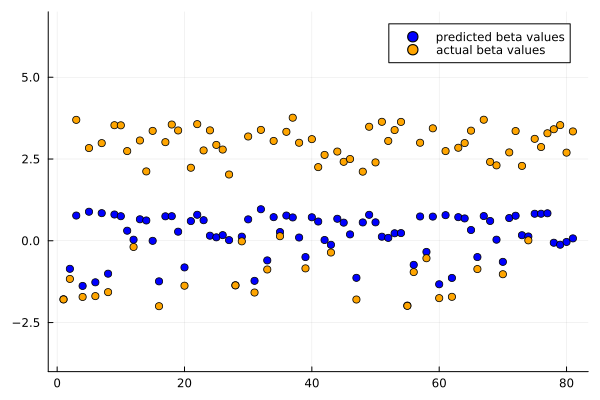

In [74]:
pred_beta_values = []
actual_beta_values = []
for j in 1:J
    for val in model.mu_beta_star[j]
        push!(pred_beta_values, val)
    end
    for val in data.mu_beta_star[j]
        push!(actual_beta_values, val)
    end
end

using Plots

x = 1:length(pred_beta_values)
plot(x, pred_beta_values, seriestype=:scatter, label = "predicted beta values", mc=:blue)
plot!(x, actual_beta_values, seriestype=:scatter, label = "actual beta values", mc=:orange)
#plot!(x, pred_beta_values, label = "", lc=:blue)
#plot!(x, actual_beta_values, label = "", lc=:orange)
ylims!(-4, 7)

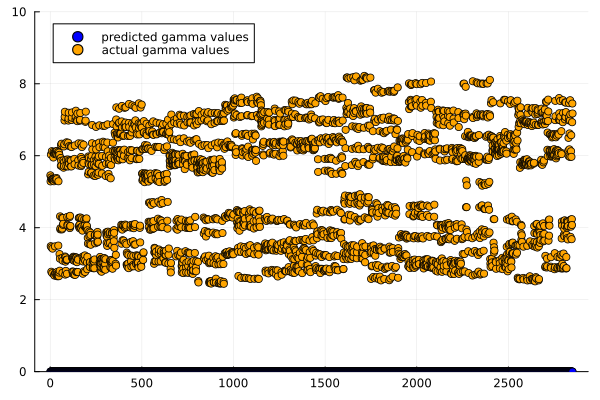

In [385]:
pred_gamma_values = []
actual_gamma_values = []
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                push!(pred_gamma_values, model.mu_gamma_star[k][t][1][s][1])
                push!(actual_gamma_values, data.mu_gamma_star[k][t][1][s][1])
            end
        else
            num_features = size(obs.X[k][t], 2)
            for z in 1:(2^(t-1))
                for s in 1:S
                    for feature in 1:num_features
                        push!(pred_gamma_values, model.mu_gamma_star[k][t][z][s][feature])
                        push!(actual_gamma_values, data.mu_gamma_star[k][t][z][s][feature])
                    end
                end
            end
        end
    end
end

x = 1:length(pred_gamma_values)
plot(x, pred_gamma_values, seriestype=:scatter, label = "predicted gamma values", mc=:blue)
plot!(x, actual_gamma_values, seriestype=:scatter, label = "actual gamma values", mc=:orange)
# plot!(x, pred_gamma_values, label = "", lc=:blue)
# plot!(x, actual_gamma_values, label = "", lc=:orange)
ylims!(0, 10)

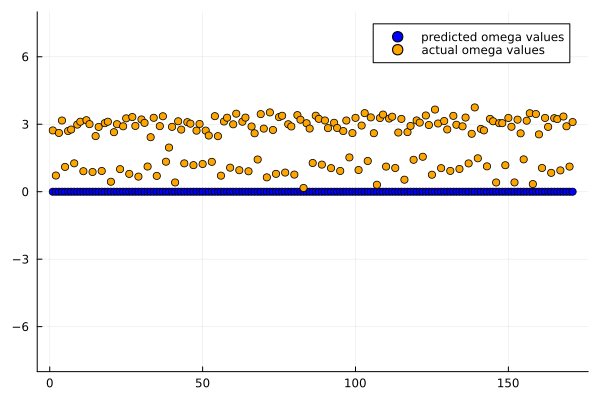

In [386]:
pred_omega_values = []
actual_omega_values = []
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                pred_omega_values = vcat(pred_omega_values, model.mu_omega_star[k][t][1][feature])
                actual_omega_values = vcat(actual_omega_values, data.mu_omega_star[k][t][1][feature])
            end
        else
            for z in 1:(2^(t-1))
                for feature in 1:num_features
                    pred_omega_values = vcat(pred_omega_values, model.mu_omega_star[k][t][z][feature])
                    actual_omega_values = vcat(actual_omega_values, data.mu_omega_star[k][t][z][feature])
                end
            end
        end
    end
end

x = 1:length(pred_omega_values)
plot(x, pred_omega_values, seriestype=:scatter, label = "predicted omega values", mc=:blue)
plot!(x, actual_omega_values, seriestype=:scatter, label = "actual omega values", mc=:orange)
# plot!(x, pred_gamma_values, label = "", lc=:blue)
# plot!(x, actual_gamma_values, label = "", lc=:orange)
ylims!(-8, 8)

## Learning beta

In [424]:
M = 10
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true)
optim = ADAMparams(model);

TDCModel constructed for computation on 12 threads


In [425]:
for i in 1:N
    for t in 1:O
        model.pi_star[i][t] .= data.pi_star[i][t] .+ .001
        model.pi_star[i][t][argmax(data.pi_star[i][t])] .- .016
    end
end

#Initialize betas in the correct direction
for j in 1:J
    model.mu_beta_star[j] = ones(length(model.mu_beta_star[j])) .* 2
    model.mu_beta_star[j][1] = -2
end


In [426]:
update_normal_variational_distribution(model, init_step = .02, maxiter = 1000, clip = 50.0, verbose = false, ADAMparams=optim)

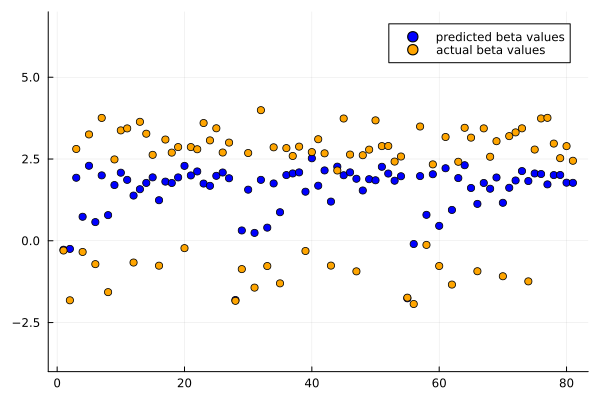

In [427]:
pred_beta_values = []
actual_beta_values = []
for j in 1:J
    for val in model.mu_beta_star[j]
        push!(pred_beta_values, val)
    end
    for val in data.mu_beta_star[j]
        push!(actual_beta_values, val)
    end
end

using Plots

x = 1:length(pred_beta_values)
plot(x, pred_beta_values, seriestype=:scatter, label = "predicted beta values", mc=:blue)
plot!(x, actual_beta_values, seriestype=:scatter, label = "actual beta values", mc=:orange)
#plot!(x, pred_beta_values, label = "", lc=:blue)
#plot!(x, actual_beta_values, label = "", lc=:orange)
ylims!(-4, 7)

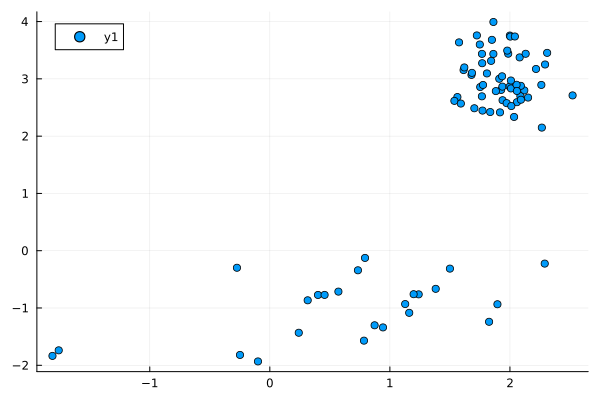

In [430]:
plot(pred_beta_values, actual_beta_values, seriestype=:scatter)

In [431]:
profile = 1

correct = zeros(J)
total = 0
for i in 1:N
    if argmax(data.pi_star[i][1]) == profile
        total += 1
        correct .+= obs.Y[i,t,:]
    end
end
prop = correct ./ total;

In [432]:
for j in 1:J
    prop_j = prop[j]
    print(sigmoid.(dot(obs.D[j][profile, :], model.mu_beta_star[j])))
    print("\t")
    print(sigmoid.(dot(obs.D[j][profile, :], data.mu_beta_star[j])))
    println("\t $prop_j")
end

0.43196550388233323	0.42612697862810917	 0.4318529862174579
0.43817830841274646	0.139484207596817	 0.12557427258805512
0.6756579044789538	0.415365613073687	 0.3874425727411945
0.6390591145452746	0.3286901087584067	 0.34762633996937214
0.6865860689527492	0.17220061598787928	 0.17151607963246554
0.7992691724730558	0.3395256007284303	 0.31852986217457885
0.77552844184471	0.3182351867142688	 0.32618683001531396
0.9080353018153353	0.4439583192423968	 0.43644716692189894
0.140577861722359	0.13749560751798404	 0.15773353751914243
0.5782042410162751	0.2961490964864768	 0.30781010719754975
0.5599604742308391	0.19274443737632674	 0.2006125574272588
0.5990089773562088	0.31593255708650536	 0.3430321592649311
0.7053374042630511	0.21384986999123692	 0.222052067381317
0.817611763858655	0.4224531970350733	 0.42879019908116384
0.7681400359768457	0.3188115446213271	 0.30321592649310875
0.8694317605263391	0.2819594259567909	 0.3016845329249617
0.1469737051671492	0.14941559660111214	 0.13476263399693722
0